## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math

Importing and formatting the training data

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")

In [3]:
# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [0]]


# Make sure variable is right
list(tornado_outcome)

['DAMAGE_PROPERTY']

In [4]:
# The predictors
tornado_predictors = tor_df.iloc[:, 2:34]

# Drop the ones that are irrelevant to this model type
tornado_predictors = tornado_predictors.drop(["TOR_LENGTH",
                                              "TOR_WIDTH",
                                              "YEAR",
                                              "MULTI_VORT_IND",
                                              "TOR_AREA",
                                              "EXP_INC_AREA",
                                              "DAY_OF_YEAR",
                                              "MONTH"],
                                             axis = 1)


# Make sure the variables are right
list(tornado_predictors)

['BEGIN_LAT',
 'BEGIN_LON',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'STATE_RANK']

In [5]:
# Make the outcomes into a numpy array
outcome_array = tornado_outcome.values

# Makes that numpy array into a torch Tensor
outcome_Tensor = torch.from_numpy(outcome_array)


# Make the predictors into a numpy array
predictors_array = tornado_predictors.values

# Make that numpy array into a torch Tensor
predictors_Tensor = torch.from_numpy(predictors_array)


# Convert those DoubleTensors to FloatTensors
# Changing outcomes from a DoubleTensor to a FloatTensor
outcome_Tensor = outcome_Tensor.float()

# Changing predictors too
predictors_Tensor = predictors_Tensor.float()

Now the cross-validation data

In [6]:
# Import cross-validation data
cv_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Get the outcomes
cv_outcome = cv_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
cv_outcome_Tensor = torch.from_numpy(cv_outcome.values).float()


# Make sure the variable is right
list(cv_outcome)

['DAMAGE_PROPERTY']

In [7]:
# Get the validation set predictors
cv_predictors = cv_df.iloc[:, 2:34]

# Drop the irrelevant ones
cv_predictors = cv_predictors.drop(["TOR_LENGTH", "TOR_WIDTH",
                                    "YEAR", "MULTI_VORT_IND",
                                    "TOR_AREA", "EXP_INC_AREA",
                                    "DAY_OF_YEAR", "MONTH"],
                                   axis = 1)

# Make the validation set predictors into a numpy array
cv_predictors_Tensor = torch.from_numpy(cv_predictors.values).float()


# Make sure the variables are right
list(cv_predictors)

['BEGIN_LAT',
 'BEGIN_LON',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'STATE_RANK']

Now the test set data

In [8]:
# Import the test set data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set.csv")


# Get the outcomes
test_outcome = test_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
test_outcome_Tensor = torch.from_numpy(test_outcome.values).float()


# Make sure the variable is right
list(test_outcome)

['DAMAGE_PROPERTY']

In [9]:
# Get the test set predictors
test_predictors = test_df.iloc[:, 2:34]

# Drop the irrelevant ones
test_predictors = test_predictors.drop(["TOR_LENGTH", "TOR_WIDTH",
                                        "YEAR", "MULTI_VORT_IND",
                                        "TOR_AREA", "EXP_INC_AREA",
                                        "DAY_OF_YEAR", "MONTH"],
                                       axis = 1)

# Make the test set predictors into a numpy array
test_predictors_Tensor = torch.from_numpy(test_predictors.values).float()


# Make sure the variables are right
list(test_predictors)

['BEGIN_LAT',
 'BEGIN_LON',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'STATE_RANK']

## 1. One-Hidden-Layer Neural Network

Define the model architecture

In [10]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(24, 16)
        self.fc2 = torch.nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)


# Make it
model = Net()

Defining a function to setup and train the models. It will also produce a loss versus iteration plot

In [11]:
def train_neural_net(model, train_outcomes, train_inputs,
                     iterations, loss_fn, optimizer,
                     cv_outcomes, cv_inputs):
    
    # This function will train the neural network and produce a loss versus iteration plot
    # learning_rate = the optimizing learning rate
    # model = the model architecture
    # train_outcomes = the right answers
    # train_inputs = what we're using to get to the right answers
    # iterations = how many times the optimizing algorithm repeats
    # loss_fn = what we're optimizing in respect to
    # optimizer = how we're going to optimize
    
    
    # Make the outcomes into a Torch Variable
    outcome_Variable = Variable(train_outcomes)
    
    # Make the cv outcomes into a Torch Variable
    cv_outcome_Variable = Variable(cv_outcomes)
    
    # Make the predictors into a Torch Variable
    predictors_Variable = Variable(train_inputs,
                                   requires_grad = False)
    
    # Make the cv predictors into a Torch Variable
    cv_predictors_Variable = Variable(cv_inputs)
    
    
    # Make an empty list to add to for each iteration
    current_loss_value = []
    
    # For the cv too
    current_cv_loss_value = []
    
    
    # Train the neural network
    for t in range(iterations):
        
        # Get the current predictions
        current_pred = model(predictors_Variable)
        cv_pred = model(cv_predictors_Variable)
        
        # Compute current loss and and append that to the empty list
        current_loss = loss_fn(current_pred, outcome_Variable)
        current_loss_value.append(current_loss.data[0])
        
        current_cv_loss = loss_fn(cv_pred, cv_outcome_Variable)
        current_cv_loss_value.append(current_cv_loss.data[0])
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss.backward()
        
        # Update model parameters
        optimizer.step()
    
    
    # Get iterations as a list for x-axis of plot
    iterations_x = list(range(0, iterations))
    
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value) / len(predictors_Variable)).tolist()
    
    # For cv too
    mse_cv = (np.asarray(current_cv_loss_value) / len(cv_predictors_Variable)).tolist()
    
    
    # Plot loss versus iteration
    plt.plot(iterations_x, mse)
    plt.plot(iterations_x, mse_cv, "r-")
    plt.xlabel("Iteration")
    plt.ylabel("Loss Value")
    plt.title("How'd the Optimizing Go?")

Set the loss function and optimizing method to use throughout the notebook

In [12]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average = False)


# Set the learning rate
learning_rate = 1e-2

# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

Train the first model.

The plot will display how well it optimized. The blue line is the data the model was optimized on, while the red line is new (cross-validation) data.

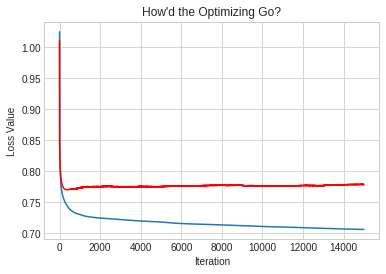

In [13]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 15000, loss_fn, optimizer, cv_outcome_Tensor,
                 cv_predictors_Tensor)

### 1.1 Performance Metrics

We're really interested in how it does on new data, so let's get some metrics of its performance on the new data.

First: Mean squared error (MSE)

In [14]:
def compute_MSE(predictors, observed_outcomes):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield

    
    # Get the validation set predictions
    cv_predictions = model(Variable(predictors, requires_grad = False))
    
    # Get the validation set outcomes
    cv_outcomes = Variable(observed_outcomes)
    
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(cv_predictions, cv_outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [15]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.7790
[torch.FloatTensor of size 1]

In [16]:
def compute_R_squared(predictors, observed_outcomes):
    
    # Computes R-squared of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    
    
    # Get the mean of the observed outcomes
    observed_mean = (sum(observed_outcomes) / len(observed_outcomes)).numpy()[0]
    
    # Fill an ndarray with that
    valid_outcomes_mean = np.repeat(observed_mean, len(observed_outcomes))
    
    # Convert that to a Variable
    valid_outcomes_mean = Variable(torch.from_numpy(valid_outcomes_mean))
    
    
    # Compute total sum of squares
    TSS = loss_fn(valid_outcomes_mean, Variable(observed_outcomes))
    
    
    # Compute residual sum of squares
    RSS = loss_fn(model(Variable(predictors)), Variable(observed_outcomes))
    
    
    # Compute R-squared
    R_squared = 1 - (RSS / TSS)
    return(R_squared)

In [17]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
 0.2107
[torch.FloatTensor of size 1]

### 1.2 Performance Visualization

In log-transformed space, plot predicted values versus observed values for new data

In [18]:
def plot_cross_valid_perf(cv_predictors, cv_obs):
    
    # Plots how well the model performs on new data
    # cv_pred = the values that the model predicts from
    # cv_obs = what the model would ideally predict
    
    
    # Get the predictions
    cv_predictions = model(Variable(cv_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    cv_predictions = cv_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    cv_predictions = (cv_predictions*5.407597 + 7.688844).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    cv_obs = (cv_obs.numpy()*5.407597 + 7.688844).tolist()
    
    
    # Plot it
    plt.scatter(cv_obs, cv_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")
    axes.set_title("Model Performance on Cross-Validation Data")
    plt.text(0.5, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))
    plt.text(0.5, 19, "MSE = %s"%(MSE.data.numpy()[0]))

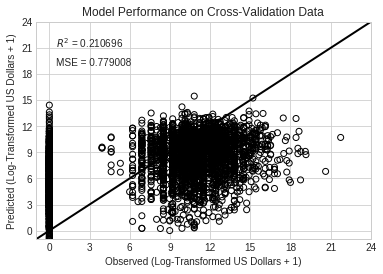

In [19]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

Lastly, let's inspect the first hidden layer's weights

In [20]:
model.fc1.weight

Parameter containing:

Columns 0 to 9 
 0.0252  0.0535 -0.0419 -0.5361  0.0734 -0.0577  0.1204  0.1471 -0.0585 -0.0211
-0.5246 -0.0395 -0.0113 -0.4055 -0.1700  0.4537 -0.0431 -0.2090 -0.1654  0.0483
-0.0071 -0.1348 -0.1946  0.0493  0.0288 -0.1229  0.4293 -0.5038  0.0474 -0.2180
 0.0846  0.0659 -0.2538 -0.3291 -0.0159 -0.0789  0.3112  0.0564  0.2040  0.0821
-0.2110  0.1863  0.3588  0.2483 -0.4259  0.2714 -0.1144  0.2075  0.2364  0.1804
-0.3108  0.1357  0.1173  0.0571  0.3400 -0.4315  0.5325 -0.0747  0.4910  0.0962
-0.3952 -0.5537  0.0121 -0.3073 -0.1865  0.2326  0.1139 -0.1970 -0.2092  0.1087
-0.1648 -0.2482 -0.1717  0.1387  0.1462 -0.1835  0.1889 -0.4130 -0.0021 -0.2939
 0.1911  0.0369 -0.3496 -0.1252 -0.0579  0.0118  0.1923  0.1898  0.0798 -0.1910
 0.1107  0.1620 -0.2973 -0.1230  0.0775  0.0194  0.2137  0.1049 -0.0954 -0.1350
 0.0424  0.0434  0.3003  0.1176 -0.0144  0.0189 -0.0694  0.0921 -0.1180  0.3063
 0.1576  0.0661 -0.2994  0.0826 -0.3145  0.3082  0.0528 -0.1348  0.4141  0.1978
-

### 1.3 Store Predictions

In [21]:
def obs_as_col(obs_Tens):
    
    # Saves observed outcomes as a pandas column
    # obs_Tens = a Tensor containing observed outcomes
    
    
    # Convert the Tensor to a list
    obs_list = obs_Tens.numpy().tolist()
    
    
    # Make an empty list
    obs_flat_list = []
    
    
    # Unnest the Tensor-list into the empty list
    for sublist in obs_list:
        for val in sublist:
            obs_flat_list.append(val)
    
    
    # Turn that list into a pandas DataFrame
    obs_pd_column = pd.DataFrame(obs_flat_list)
    return(obs_pd_column)

In [22]:
cv_stored = obs_as_col(cv_outcome_Tensor)

cv_stored.columns = ["observed"]

In [23]:
test_stored = obs_as_col(test_outcome_Tensor)

test_stored.columns = ["observed"]

In [24]:
def add_to_stored(new_col_name, pred_Tens, already_made):
    
    model_pred = model(Variable(pred_Tens)).resize(len(pred_Tens))
    
    model_pred = model_pred.data.numpy()
    
    already_made[new_col_name] = pd.Series(model_pred, index = cv_stored.index)

In [25]:
add_to_stored("cv_pred_1", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_1", test_predictors_Tensor, test_stored)

## 2. Two-Hidden-Layer Neural Network

In [26]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(24, 16)
        self.fc2 = torch.nn.Linear(16, 11)
        self.fc3 = torch.nn.Linear(11, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

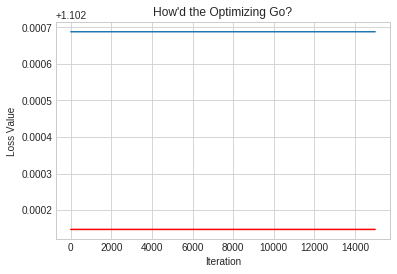

In [27]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 15000, loss_fn, optimizer, cv_outcome_Tensor,
                 cv_predictors_Tensor)

### 2.1 Performance Metrics

In [28]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 1.1021
[torch.FloatTensor of size 1]

In [29]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
-0.1167
[torch.FloatTensor of size 1]

### 2.2 Performance Visualization

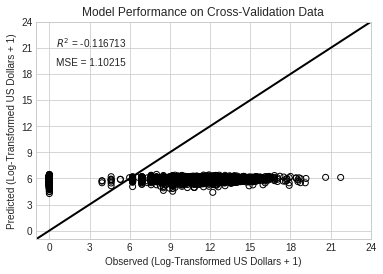

In [30]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [31]:
model.fc1.weight

Parameter containing:

Columns 0 to 9 
 0.0656 -0.0417 -0.0069  0.1472  0.0217  0.0171 -0.0451 -0.0750 -0.0280  0.0561
 0.0946  0.0443  0.1573  0.1894  0.0509  0.0237 -0.1492 -0.0245  0.1405  0.1961
-0.0009  0.0429 -0.1140 -0.0889  0.1173  0.1745  0.0335  0.0166  0.1191 -0.1172
 0.0077  0.1598  0.0008 -0.0477  0.0964  0.0400 -0.0913  0.1889 -0.1590  0.0185
 0.0879 -0.0440  0.0566 -0.0329 -0.1122  0.0402  0.0425  0.2005 -0.1683 -0.0570
 0.1625 -0.1818  0.1860  0.1745  0.2012 -0.1028  0.0364 -0.1828 -0.1726  0.1098
 0.0941  0.0350  0.0760  0.0716  0.1933  0.0579  0.1927 -0.1224  0.1165  0.1806
 0.0235 -0.1610  0.1274 -0.0708  0.0296 -0.0194 -0.1718 -0.0861 -0.1057  0.1076
-0.1985 -0.0718 -0.1199  0.0957 -0.0802  0.1117 -0.0622 -0.0403  0.1127  0.0892
-0.0417 -0.0025  0.0195 -0.0068  0.0196 -0.1048  0.0188 -0.0914  0.1100  0.1749
 0.0050 -0.1046  0.1491 -0.2001 -0.1946 -0.0860  0.0412 -0.1584  0.0100 -0.2038
 0.0463  0.1113 -0.1972 -0.0741  0.1951 -0.1923  0.1769 -0.2001  0.1758  0.1757
-

### 2.3 Store Predictions

In [32]:
add_to_stored("cv_pred_2", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_2", test_predictors_Tensor, test_stored)

## 3. Three-Hidden-Layer Neural Network

In [33]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(24, 16)
        self.fc2 = torch.nn.Linear(16, 11)
        self.fc3 = torch.nn.Linear(11, 7)
        self.fc4 = torch.nn.Linear(7, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return(x)


# Make it
model = Net()

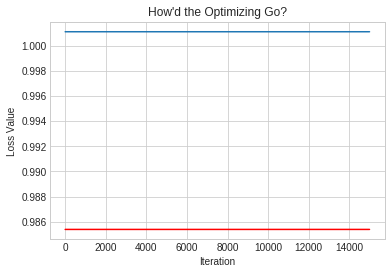

In [34]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 15000, loss_fn, optimizer, cv_outcome_Tensor,
                 cv_predictors_Tensor)

### 3.1 Performance Metrics

In [35]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.9854
[torch.FloatTensor of size 1]

In [36]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
1.00000e-03 *
  1.5904
[torch.FloatTensor of size 1]

### 3.2 Performance Visualization

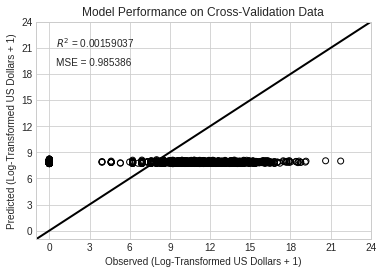

In [37]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [38]:
model.fc1.weight

Parameter containing:

Columns 0 to 9 
-0.0708  0.0216  0.1591  0.0803 -0.1940 -0.0310 -0.0598 -0.0353 -0.1320 -0.0023
-0.0565  0.1884 -0.0549  0.1245 -0.1593 -0.0626  0.1341 -0.0603 -0.0743  0.0909
-0.0731 -0.0066 -0.1432  0.0219  0.0693 -0.0601 -0.0125  0.0404  0.1706  0.0910
-0.1222  0.1616  0.1476  0.0561  0.0902 -0.1159 -0.0339 -0.1786 -0.0748  0.1526
-0.0838 -0.1748  0.1642 -0.1968  0.0040 -0.0911  0.0834  0.1006 -0.0927  0.1193
 0.0428 -0.0091 -0.1634  0.0412 -0.0268 -0.1695  0.1909 -0.1252  0.0063 -0.1352
 0.1130  0.1164  0.0294 -0.0817 -0.1656  0.0199 -0.0598  0.0407 -0.1736  0.1344
 0.1213 -0.0286 -0.0331 -0.0339  0.0740  0.0497 -0.1642 -0.1444 -0.1768 -0.1480
 0.1627  0.1901 -0.1359  0.1088  0.0778 -0.1448 -0.0599  0.0147  0.0230  0.1699
 0.0447  0.1585  0.0900  0.0623  0.1479 -0.0415 -0.1247 -0.0885 -0.1283 -0.0134
-0.1085 -0.0967  0.1228  0.0440 -0.1953  0.1245  0.1644  0.0563 -0.0431  0.1347
 0.1614  0.0224  0.1815  0.1095  0.1582  0.0247  0.1974  0.0022 -0.0511  0.1968
 

### 3.3 Store Predictions

In [39]:
add_to_stored("cv_pred_3", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_3", test_predictors_Tensor, test_stored)

## 4. Four-Hidden-Layer Neural Network

In [40]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(24, 16)
        self.fc2 = torch.nn.Linear(16, 11)
        self.fc3 = torch.nn.Linear(11, 7)
        self.fc4 = torch.nn.Linear(7, 5)
        self.fc5 = torch.nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        return(x)


# Make it
model = Net()

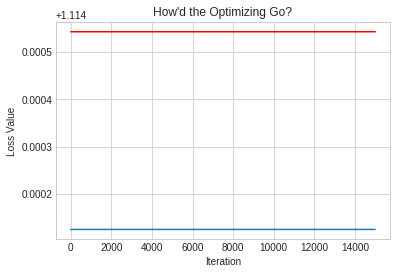

In [41]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 15000, loss_fn, optimizer, cv_outcome_Tensor,
                 cv_predictors_Tensor)

### 4.1 Performance Metrics

In [42]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 1.1145
[torch.FloatTensor of size 1]

In [43]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
-0.1293
[torch.FloatTensor of size 1]

### 4.2 Performance Visualization

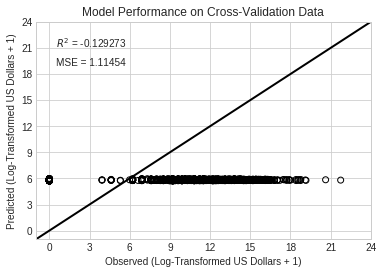

In [44]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [45]:
model.fc1.weight

Parameter containing:

Columns 0 to 9 
 0.1195 -0.0192 -0.0371 -0.1909 -0.0970 -0.1887 -0.1195 -0.0854  0.1105  0.0452
 0.2036 -0.0630  0.0000 -0.1980  0.0353 -0.0585 -0.0178  0.1957 -0.0996 -0.1311
 0.1724  0.0026  0.0857 -0.1139 -0.1649  0.1295 -0.1344 -0.1606  0.1935  0.0447
-0.1559  0.0354  0.1800 -0.1314  0.0851 -0.0122 -0.0170 -0.1724  0.0871  0.1410
-0.0871  0.0802  0.1454  0.0871 -0.1365  0.0375 -0.0106 -0.1981 -0.0200  0.0771
-0.2031  0.1535 -0.0511 -0.1341 -0.0526  0.1587 -0.0276  0.1314 -0.0974 -0.0713
 0.1101  0.0237 -0.0952  0.1577 -0.0946  0.1473  0.1212 -0.2017 -0.0038 -0.1028
-0.1715  0.0409 -0.0448  0.1848 -0.1725  0.0389  0.0599  0.0920  0.1994  0.2037
 0.0429 -0.1856  0.1296 -0.1391 -0.1951  0.0747  0.2013 -0.1320 -0.1591  0.0626
 0.0720  0.1299  0.0324  0.0548  0.0675  0.1554 -0.0260 -0.1642  0.0257 -0.1474
 0.0227  0.0241 -0.2040  0.1915  0.0645 -0.0570 -0.1639  0.0201  0.0517  0.0655
 0.0075  0.1879 -0.1352 -0.1099  0.1973  0.0203  0.0192 -0.0077 -0.1666 -0.1881
-

### 4.3 Store Predictions

In [46]:
add_to_stored("cv_pred_4", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_4", test_predictors_Tensor, test_stored)

## 5. Five-Hidden-Layer Neural Network

In [47]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(24, 16)
        self.fc2 = torch.nn.Linear(16, 11)
        self.fc3 = torch.nn.Linear(11, 7)
        self.fc4 = torch.nn.Linear(7, 5)
        self.fc5 = torch.nn.Linear(5, 3)
        self.fc6 = torch.nn.Linear(3, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = torch.nn.functional.relu(self.fc5(x))
        x = self.fc6(x)
        return(x)


# Make it
model = Net()

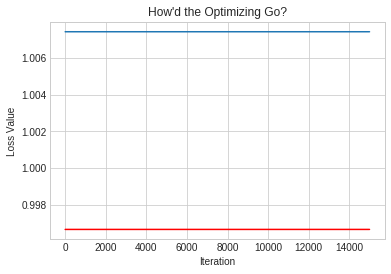

In [48]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 15000, loss_fn, optimizer, cv_outcome_Tensor,
                 cv_predictors_Tensor)

### 5.1 Performance Metrics

In [49]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 0.9966
[torch.FloatTensor of size 1]

In [50]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
1.00000e-03 *
 -9.8134
[torch.FloatTensor of size 1]

### 5.2 Performance Visualization

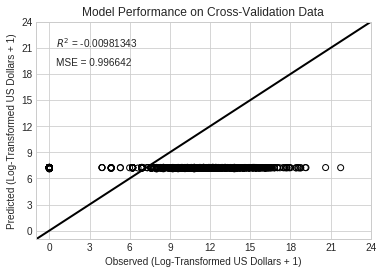

In [51]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [52]:
model.fc1.weight

Parameter containing:

Columns 0 to 9 
 0.1158 -0.1406 -0.0199 -0.0553 -0.1576 -0.0467  0.1109 -0.1775  0.1739 -0.1959
-0.0132  0.1986 -0.0528 -0.0686  0.1520 -0.0162  0.1252 -0.0791  0.1145 -0.0317
-0.0923  0.1378 -0.0579  0.0403 -0.1002 -0.0665 -0.1125  0.0691 -0.1859  0.1785
-0.0785 -0.0606 -0.0373 -0.1137  0.1759 -0.1857 -0.0530 -0.0020  0.0086 -0.1428
-0.1185  0.0846  0.0654 -0.0769 -0.0961 -0.1728 -0.0530  0.0410 -0.0398  0.0689
 0.0057  0.1411  0.1591 -0.1002  0.0847 -0.1929 -0.1169 -0.0925 -0.1369 -0.0198
 0.1382  0.1825  0.0519  0.1250  0.1214 -0.0874 -0.1180 -0.0788 -0.1151 -0.0103
 0.1110  0.0742 -0.0572 -0.1713  0.2038  0.1200  0.1093 -0.1492 -0.1449 -0.0805
 0.0329  0.0294  0.1629 -0.0822 -0.0448  0.1645  0.1452  0.1047  0.1288 -0.0539
 0.0102 -0.0901  0.0485  0.1567 -0.0785 -0.0126 -0.1667  0.1112 -0.0947 -0.0079
-0.0089  0.0237  0.1419 -0.1552  0.1067  0.0055  0.2032 -0.0374 -0.1797  0.1946
-0.1533  0.0339 -0.0769 -0.1233 -0.0210 -0.0938 -0.0496 -0.0386  0.1688  0.0133
 

### 5.3 Store Predictions

In [53]:
add_to_stored("cv_pred_5", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_5", test_predictors_Tensor, test_stored)

## 6. Six-Hidden-Layer Neural Network

In [54]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(24, 16)
        self.fc2 = torch.nn.Linear(16, 11)
        self.fc3 = torch.nn.Linear(11, 7)
        self.fc4 = torch.nn.Linear(7, 5)
        self.fc5 = torch.nn.Linear(5, 3)
        self.fc6 = torch.nn.Linear(3, 2)
        self.fc7 = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = torch.nn.functional.relu(self.fc5(x))
        x = torch.nn.functional.relu(self.fc6(x))
        x = self.fc7(x)
        return(x)


# Make it
model = Net()

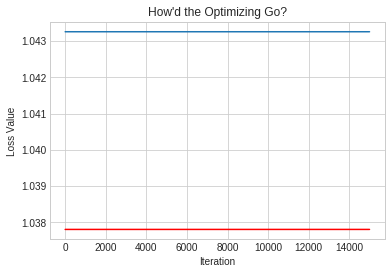

In [55]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 15000, loss_fn, optimizer, cv_outcome_Tensor,
                 cv_predictors_Tensor)

### 6.1 Performance Metrics

In [56]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 1.0378
[torch.FloatTensor of size 1]

In [57]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
1.00000e-02 *
 -5.1515
[torch.FloatTensor of size 1]

### 6.2 Performance Visualization

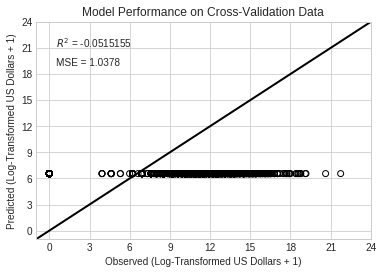

In [58]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [59]:
model.fc1.weight

Parameter containing:

Columns 0 to 9 
-0.0674  0.0585 -0.1291 -0.0710 -0.0823 -0.0830  0.0256 -0.0162  0.1409 -0.0339
-0.1896  0.0085  0.1472 -0.1653 -0.0915 -0.0059 -0.0642  0.0934  0.0157  0.0444
-0.1113 -0.1014  0.2037 -0.0751  0.0852  0.1535 -0.0271  0.1302 -0.0250  0.1480
-0.0567  0.0432  0.0017  0.1733  0.1546  0.0346  0.0692 -0.1023  0.1302  0.1296
 0.1810  0.1670 -0.1240  0.0504 -0.0631 -0.0060  0.1771 -0.0118 -0.0272  0.1411
-0.0766 -0.1598  0.1619  0.1926  0.0102 -0.1442 -0.0907 -0.0620  0.0085  0.0774
-0.1242 -0.1359  0.1496 -0.0574  0.1919  0.0292  0.1560 -0.1266 -0.1487 -0.0675
-0.0103 -0.1969  0.0203 -0.1617 -0.0598  0.0372 -0.0179  0.1484 -0.1711 -0.1440
-0.0401 -0.1565 -0.1875  0.0998 -0.1982 -0.0565 -0.0546 -0.0804 -0.1587 -0.1422
 0.1245 -0.1520  0.0798  0.1504  0.1330  0.1087  0.0825 -0.1223 -0.0588 -0.1876
 0.0142  0.0591  0.1472 -0.1955  0.1538  0.0590  0.0389 -0.1160 -0.1306  0.1191
-0.0534  0.0910 -0.0900  0.0832 -0.0239  0.0243  0.0368  0.1604  0.0013  0.1406
-

### 6.3 Store Predictions

In [60]:
add_to_stored("cv_pred_6", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_6", test_predictors_Tensor, test_stored)

## 7. Linear Regression

In [61]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(24, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        return(x)


# Make it
model = Net()

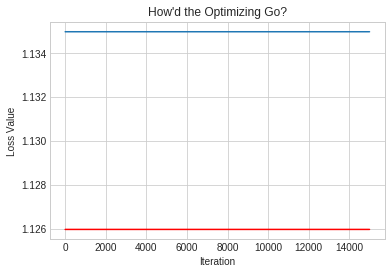

In [62]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 15000, loss_fn, optimizer, cv_outcome_Tensor,
                 cv_predictors_Tensor)

### 7.1 Performance Metrics

In [63]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)
MSE

Variable containing:
 1.1260
[torch.FloatTensor of size 1]

In [64]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)
R_squared

Variable containing:
-0.1408
[torch.FloatTensor of size 1]

### 7.2 Performance Visualization

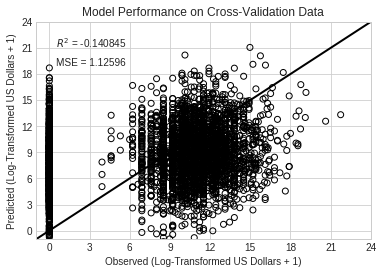

In [65]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [66]:
model.fc1.weight

Parameter containing:

Columns 0 to 9 
 0.1835 -0.0017  0.0404  0.1956  0.0138  0.0121  0.0337 -0.1285  0.1711  0.1232

Columns 10 to 19 
-0.0073 -0.0907  0.2035 -0.0466 -0.1532 -0.0513 -0.1846 -0.1056 -0.0016  0.1944

Columns 20 to 23 
 0.1450  0.1043 -0.0369 -0.1610
[torch.FloatTensor of size 1x24]

### 7.3 Store Predictions

In [67]:
add_to_stored("cv_pred_7", cv_predictors_Tensor, cv_stored)

add_to_stored("test_pred_7", test_predictors_Tensor, test_stored)

In [68]:
cv_stored.head()

,observed,cv_pred_1,cv_pred_2,cv_pred_3,cv_pred_4,cv_pred_5,cv_pred_6,cv_pred_7
0,0.677117,-0.068599,-0.389445,0.018896,-0.344952,-0.084005,-0.209767,0.395025
1,0.484530,-0.984434,-0.389235,0.006808,-0.341265,-0.081923,-0.209760,0.596722
2,0.058780,0.078701,-0.341907,0.046172,-0.328800,-0.080563,-0.209787,0.800099
3,-1.421860,-0.558317,-0.332685,0.023286,-0.343791,-0.086832,-0.209773,-0.311166
4,-1.421860,-0.981630,-0.379327,0.042896,-0.357324,-0.083710,-0.209732,-1.059171


In [69]:
test_stored.head()

,observed,test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5,test_pred_6,test_pred_7
0,0.356356,-1.082063,-0.299564,0.023465,-0.354372,-0.086228,-0.209734,-0.617620
1,1.132974,-0.638459,-0.282162,0.012359,-0.333572,-0.082759,-0.209718,-0.576426
2,0.578992,0.545371,-0.306591,0.042310,-0.342538,-0.091696,-0.209641,-0.373287
3,-1.421860,-0.148617,-0.302297,0.052378,-0.336708,-0.090050,-0.209754,0.760196
4,-1.421860,-0.711430,-0.316136,0.026851,-0.353738,-0.083962,-0.209762,-0.283409


In [70]:
# Save the stored predictions and outcomes as a .csv
cv_stored.to_csv("12_cv_perf.csv")

test_stored.to_csv("12_test_perf.csv")